## Collaborative Filtering

Collaborative Filtering is a commonly used approach for recommender systems. In this notebook I will be using the "movie lens 100k" data set to further my understanding of how recommender systems are constructed. This includes constructing a sparse user-item(user-movie) matrix, weighing the pros and cons of the various imputing methods (mean, zero, KNN, SGD(didn't implement), using the sparse matrix to find similarities between users, and ultimately scoring movies to be recommended based on user and user similarities. 

---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#### Import Data 

In [2]:
movies_df = pd.read_csv('ml-latest-small/movies.csv')
ratings_df = pd.read_csv('ml-latest-small/ratings.csv')

In [3]:
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
movies_df.shape

(9742, 3)

In [5]:
ratings_df.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


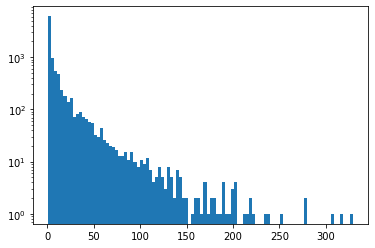

In [6]:
rating_count = ratings_df.groupby('movieId')['rating'].count()
plt.hist(rating_count, bins= 100, log=True)
plt.show()

In [7]:
rating_count.quantile(np.arange(1, 0.6, -0.05))

1.00    329.0
0.95     47.0
0.90     27.0
0.85     17.0
0.80     12.0
0.75      9.0
0.70      7.0
0.65      5.0
Name: rating, dtype: float64

obviously very skewed data ... lets only select movies above the 85 % threshold

In [8]:
movies_keep = rating_count[rating_count > 17].index
ratings_df = ratings_df[ratings_df['movieId'].isin(movies_keep)]
ratings_df.shape

(70148, 4)

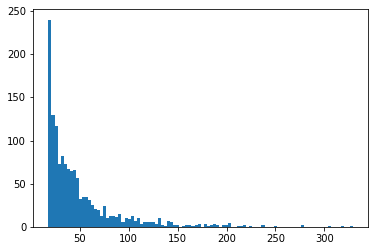

In [9]:
rating_count = ratings_df.groupby('movieId')['rating'].count()
plt.hist(rating_count, bins= 100)
plt.show()

In [10]:
avg_ratings = ratings_df.groupby('userId', as_index=False)['rating'].mean()
ratings_df = ratings_df.merge(avg_ratings, on='userId')
ratings_df.head()

,userId,movieId,rating_x,timestamp,rating_y
0,1,1,4.0,964982703,4.396825
1,1,3,4.0,964981247,4.396825
2,1,6,4.0,964982224,4.396825
3,1,47,5.0,964983815,4.396825
4,1,50,5.0,964982931,4.396825


In [11]:
df = ratings_df.merge(movies_df, on='movieId')
df['norm_rating'] = df['rating_y'] - df['rating_x']

In [12]:
df.sort_values(['userId', 'movieId']).head()

,userId,movieId,rating_x,timestamp,rating_y,title,genres,norm_rating
0,1,1,4.0,964982703,4.396825,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0.396825
215,1,3,4.0,964981247,4.396825,Grumpier Old Men (1995),Comedy|Romance,0.396825
267,1,6,4.0,964982224,4.396825,Heat (1995),Action|Crime|Thriller,0.396825
369,1,47,5.0,964983815,4.396825,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,-0.603175
572,1,50,5.0,964982931,4.396825,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,-0.603175


In [13]:
check = df.pivot(index='userId', columns='movieId', values='rating_x')

/Users/pittssp/miniconda3/envs/tf-scratch/lib/python3.7/site-packages/matplotlib/axes/_axes.py:7855: RuntimeWarning: invalid value encountered in greater
  mask = np.abs(Z) > precision


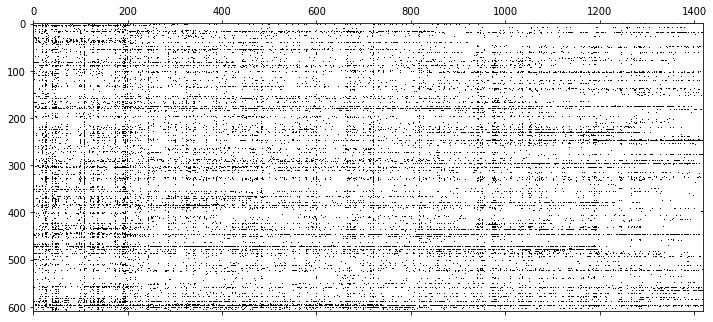

In [14]:
plt.figure(figsize=(12,12))
plt.spy(check)
# I just think this is cool :) 

In [15]:
feats_df = df.pivot(index='userId', columns='movieId', values='norm_rating')
# feats_df = df.pivot(index='userId', columns='movieId', values='rating_x')
feats_df.head()

movieId,1,2,3,5,6,7,10,11,12,14,...,134853,138036,139385,142488,148626,152081,164179,166528,168252,176371
userId,,,,,,,,,,,,,,,,,,,,,
1,0.396825,NaN,0.396825,NaN,0.396825,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,-0.390244,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Filling in NaNs 

In [16]:
# Replacing NaN by Movie (column) Average
final_movie = feats_df.fillna(feats_df.mean(axis=0))

# Replacing NaN by User (row) Average
final_user = feats_df.apply(lambda row: row.fillna(row.mean()), axis=1)

# Replacing NaN with zero
final_zero = feats_df.fillna(0)

In [17]:
from sklearn.impute import KNNImputer

final_knn = pd.DataFrame(KNNImputer(missing_values=np.nan, n_neighbors=4, 
                         weights='distance').fit_transform(check),
                        columns=feats_df.columns)

In [18]:
final_knn.head()

movieId,1,2,3,5,6,7,10,11,12,14,...,134853,138036,139385,142488,148626,152081,164179,166528,168252,176371
0,4.000000,4.171689,4.000000,3.000000,4.000000,3.298900,3.710914,3.498536,2.891915,4.540394,...,1.000000,4.128364,4.655913,4.553363,4.383781,4.500000,4.153295,4.491358,4.841091,4.262901
1,4.250000,3.500000,2.591854,2.305585,3.576075,3.000000,3.375000,5.000000,3.639313,3.604325,...,3.546918,4.234575,3.622003,4.005775,4.493361,4.000000,4.470616,4.219402,4.528891,4.104208
2,3.700000,3.093781,1.352821,3.140629,2.365348,2.657427,4.500000,3.032953,1.499213,3.550301,...,3.437043,2.902786,3.230261,3.620659,3.677282,4.204049,4.101334,4.062500,4.290665,3.244843
3,4.143738,3.524603,3.695101,3.208823,3.215089,3.539886,3.827835,3.383251,2.324660,3.517639,...,3.260509,3.494762,3.487984,4.008392,3.513338,3.607242,3.519377,4.509046,4.500869,3.856832
4,4.000000,3.117315,4.000000,3.000000,3.000000,3.000000,3.329771,3.489775,3.000000,3.000000,...,1.000000,3.627258,3.880285,3.979556,3.779359,4.239746,4.157610,3.901770,4.245974,4.000000


In [19]:
set(final_zero.columns) - set(final_knn.columns) # checking columns

set()

In [20]:
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

# calculating cosine similarity matrix between all user's depending on how we will df 
def get_sim(df):
    temp = cosine_similarity(df)
    np.fill_diagonal(temp, 0)
    temp = pd.DataFrame(temp, index=df.index)
    temp.columns = df.index
    return temp


# find users with highest cosine similarity scores between 1 user and the next 
def find_knn(df,n):
    return df.apply(lambda x: pd.Series(x.sort_values(ascending=False)
                                      .iloc[:n].index, 
                                      index=['top{}'.format(i) for i in range(1, n+1)]), axis=1)

#### checking get_sim and find_knn with sample data

checking cosine similarity logic

In [21]:
cosine_data = pd.DataFrame([[1, 5, 5],
                            [5, 1, 1],
                            [1, 4, 4]])
# user 0 - most similar to user 2
# user 1 - more similar to user 2 than user 1, both unsimilar
# user 2 - more similar to user 0 than user 1
get_sim(cosine_data)
# look at find neighbors for further exploration

,0,1,2
0,0.000000,0.404226,0.999406
1,0.404226,0.000000,0.435516
2,0.999406,0.435516,0.000000


In [22]:
find_knn(get_sim(cosine_data),2)

,top1,top2
0,2,1
1,2,0
2,0,1


checking how cosine similarity changes with sparse matrix (zeros)

In [23]:
sparse_data = pd.DataFrame([[1,4,0,0,5],
                            [0,0,5,0,1],
                            [1,4,0,0,0],
                            [3,0,5,3,1]])

# get_sim(sparse_data)

In [24]:
find_knn(get_sim(sparse_data),2)

,top1,top2
0,2,3
1,3,0
2,0,3
3,1,0


In [25]:
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

csr = csr_matrix(sparse_data)
csr.todense()
# pd.DataFrame(NearestNeighbors(n_jobs=-1, n_neighbors=2, algorithm='brute', metric='cosine').fit(csr). \
#     kneighbors(return_distance=False))

matrix([[1, 4, 0, 0, 5],
        [0, 0, 5, 0, 1],
        [1, 4, 0, 0, 0],
        [3, 0, 5, 3, 1]], dtype=int64)

In [26]:
test_impute = pd.DataFrame(KNNImputer(missing_values=0, n_neighbors=4, 
                         weights='distance').fit_transform(sparse_data))
test_impute.head()

,0,1,2,3,4
0,1.0,4.0,5.0,3.0,5.0
1,3.0,4.0,5.0,3.0,1.0
2,1.0,4.0,5.0,3.0,5.0
3,3.0,4.0,5.0,3.0,1.0


In [27]:
pd.DataFrame(NearestNeighbors(n_jobs=-1, n_neighbors=2, algorithm='brute', metric='cosine').fit(test_impute). \
    kneighbors(return_distance=False))

,0,1
0,2,1
1,3,2
2,0,1
3,1,2


results from Nearest Neighbors reports same as our find_knn function

---
### Recommender Algorithm

In [28]:
# converting MovieId to string for joining to list 
ratings_df = ratings_df.astype({"movieId": str})

# creating dataframe where for each user we have list of movies seen 
movie_user = ratings_df.groupby(by = 'userId')['movieId'].apply(lambda x:','.join(x))
movie_user.head()

userId
1    1,3,6,47,50,70,101,110,151,163,216,223,231,235...
2    318,333,1704,3578,6874,8798,46970,48516,58559,...
3    31,527,647,720,849,914,1093,1263,1272,1275,130...
4    21,32,45,47,52,58,215,235,247,260,265,296,319,...
5    1,21,34,36,39,50,58,110,150,153,247,253,261,26...
Name: movieId, dtype: object

In [29]:
def find_rec(user, sparse_matrix):
    """
    
    find_rec is dependent on sim_df, i.e. which method is used to fill in sparse matrix 
            - ideally I want to try SGD method in filling in sparse matrix w/ SVD or PCA 
            to determine best features for movie recommendation 
                http://nicolas-hug.com/blog/matrix_facto_1
    
    :param: user - userId whom you wish to retrieve list of movie recommendation's for
    :param: sim_df - similarity matrix
        must be either 'final_movie', 'final_user', 'final_zero', or 'final_knn'
        each differs in how NaN values are filled, movie avg, user avg, zero value, or knn_imputer
    
    """
    
    # get list of movies user has seen
    movies_seen = check.columns[check[check.index==user].notna().any()].tolist()
    
    # get list of similar users based on cosine similarity 
    # results are largely dependent on which method is used to fill in for NaNs
    sim_df = get_sim(sparse_matrix) # cosine similarity
    knn_df = find_knn(sim_df, 10) # top 30 users based on similarity 
    close_users = knn_df[knn_df.index == user].values[0].tolist()
    
    # map nearby neighbors to find which movies should be under consideration
    similarly_seen = movie_user[movie_user.index.isin(close_users)].values
    similarly_seen = ','.join(similarly_seen).split(',')
    
    # take difference from what user has seen and what close user's have seen
    not_seen = set(similarly_seen) - set(movies_seen)
    not_seen = list(map(int, not_seen))

    # take only movies that user has not seen and what neighbors have rated
    # use final_zero so that we only capture movies that similar users have reviewed
    # i.e. movies that similar users have not seen are 0 and hold no weight for ranking propensity 
    related_movies = final_zero.loc[:, not_seen]
    
    # select only users (rows) that are neighbors to given user
    related_movies = related_movies[related_movies.index.isin(close_users)]
    related_movies = related_movies[related_movies.notnull()]
    
    # select user cosine similarity w/ respect to other users
    corr = sim_df.loc[user, :]
    fin = pd.concat([related_movies, corr], axis=1).dropna()
    
    # multiply given user cosine similarity and similar users' movie ratings  
    fin_corr_x_score = pd.DataFrame([fin.iloc[:,i]*fin.iloc[:,-1]
                                     for i in range(len(fin.columns[:-1]))]).T
    fin_corr_x_score.columns = fin.columns[:-1].tolist()
    
    # sum user corr_x_score i.e. (cosine sim x similar users' ratings)
    pre_score = fin_corr_x_score.sum() 
    
    # get final score by adding average to pre_score
    final_score = pd.DataFrame((pre_score).sort_values(ascending=False),
                               columns=['score'])
    final_score = final_score.reset_index()
    
    recommendations = final_score.join(movies_df, on='index').dropna()
    return recommendations[['title', 'score']]
#     return sim_matrix

In [30]:
find_rec(1, final_zero)
# final_zero

,title,score
0,My Life (1993),1.732834
1,Willow (1988),1.235822
2,Land Before Time III: The Time of the Great Gi...,1.143086
3,Party Girl (1995),1.078674
4,Lady and the Tramp (1955),1.056482
...,...,...
1311,Selena (1997),-0.783817
1312,Quiz Show (1994),-0.841289
1313,"Broken Hearts Club, The (2000)",-0.861452
1314,Picture Perfect (1997),-0.907066


In [31]:
find_rec(1, final_movie)

,title,score
0,Terminal Velocity (1994),1.399755
1,"Apple Dumpling Gang, The (1975)",1.137782
3,Maximum Overdrive (1986),1.099984
4,Ever After: A Cinderella Story (1998),1.024684
5,My Crazy Life (Mi vida loca) (1993),0.910519
...,...,...
145,Virtuosity (1995),-0.929372
146,Teenage Mutant Ninja Turtles II: The Secret of...,-1.015256
147,Cemetery Man (Dellamorte Dellamore) (1994),-1.584331
148,"Age of Innocence, The (1993)",-1.726500


In [32]:
# find_rec(2, final_user)  # results identicial to final_zero, bc sim_matrix nearly identical 

In [33]:
find_rec(1, final_knn)

,title,score
0,Robin Hood: Men in Tights (1993),4.838085
1,Zeus and Roxanne (1997),4.423369
2,"Shawshank Redemption, The (1994)",3.851995
3,Restoration (1995),3.474971
4,Reckless (1995),3.474027
...,...,...
606,Kiss of Death (1995),-2.958599
607,Virtuosity (1995),-3.079944
608,"Age of Innocence, The (1993)",-3.454606
609,I Love Trouble (1994),-4.170794


### Draw backs of this approach, 
    - very common items (movies) tend to consistently appear in recommendations
    
    - method used to fill in sparse matrix gives very different results 
    
    - method to fill sparse matrix is extremely likely under capturing user's ratings
        - SGD Method to counter (http://nicolas-hug.com/blog/matrix_facto_1) 
        - put min function here ... 
        
    - cosine similarity may not capture entire full 'distances' between users/ movies
        - SVD to reduce dimension 
        - DNN to do something else idk